# Building a neural network

### Neural networks in code

Building a neural network from scratch in code is no mean feat. Some people make a habit out of it, sometimes going so far as to [live code a neural net library in one hour](https://www.youtube.com/watch?v=o64FV-ez6Gw).

Fortunately, Python [is batteries-included](https://xkcd.com/353/) and has a wonderful community of ML practitioners. There are a number of wonderful, fully-developed and well-supported libraries out there for building and training neural networks.

### Keras 

[Keras](https://keras.io/) is a high-level deep learning library, built to be simple, clear, and easy to use. It's my favourite of the neural network packages. With it, you can build and train a neural network, on a CPU or GPU, very quickly.

The API that Keras provides is its true strength. The heavy lifting -- backpropagation and gradient descent -- are provided by other, lower-level frameworks, such as TensorFlow or Theano.

### Let's dive straight into an example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

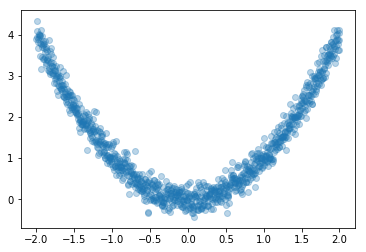

In [2]:
# Generate some data
x = np.linspace(-2, 2, 1000).reshape(-1, 1)
y = x**2 + np.random.randn(*x.shape) * 0.2

# Visualise it in a scatter plot
plt.scatter(x, y, alpha=0.3)

Let's pull a few pieces from Keras.

In [3]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Next, let's put together a tiny neural net, with only one hidden layer.

In [4]:
np.random.seed(3)

In [5]:
# A "sequential" model -- a feed-forward neural network
model = Sequential()

# Let's add two fully-connected layers : one hidden, one output
model.add(Dense(2, activation="relu", input_dim=1))
model.add(Dense(1, activation="linear"))

We're done defining the net itself. We now need to provide some information about the loss function and gradient descent options.

In [6]:
# We'll use vanilla stochastic gradient descent, and the mean squared error
model.compile(optimizer="sgd", loss="mse")

We're ready to train the net.

In [7]:
history = model.fit(x, y, epochs=30, verbose=0)

How did we do ?

In [8]:
def plot_network_results(x=x, y=y, model=model, history=history):
    """Plot the predictions and the loss history for the model."""
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(121)
    plt.scatter(x, y, alpha=0.3)
    plt.plot(x, model.predict(x), lw=5, c="k")
    plt.legend(["Prediction", "Data"])
    
    plt.subplot(122)
    plt.plot(history.history["loss"], lw=5)
    plt.title("Loss")
    plt.xlabel("Epochs")

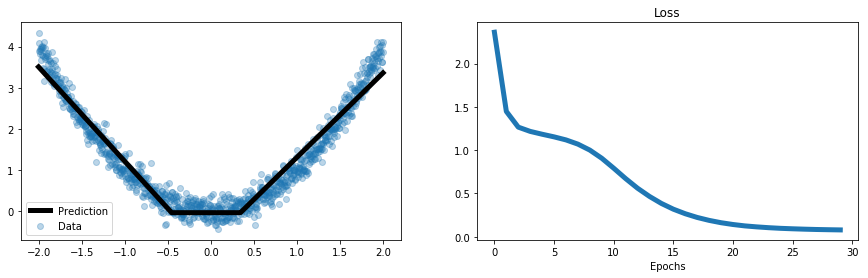

In [9]:
plot_network_results()

A tiny neural network, with one hidden layer containing two units, was able to learn a good approximation of our function.

We say "tiny", but how small is it, really ?

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


### Predicting commute times

Without further ado, let's train a larger network on some more realistic data.

In [11]:
import pandas as pd

# Let's import our data
training_data = pd.read_csv("../data/train_data_processed.csv", index_col=[0])
test_data = pd.read_csv("../data/test_data_processed.csv", index_col=[0])

In [12]:
training_data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,commute_time,time_of_day,euclidean_distance,manhattan_distance,is_BIKE,is_BUS,is_CAR,is_TRAIN
0,-0.182809,0.361579,0.485623,0.300347,25.156297,16.933333,0.671231,0.729664,0,1,0,0
1,0.160297,0.064330,0.702545,-0.116307,12.937429,18.316667,0.571544,0.722885,0,0,1,0
2,0.762229,0.486693,0.197252,0.790051,29.013729,17.600000,0.641268,0.868335,1,0,0,0
3,0.187947,0.508487,-0.372924,-0.914006,18.215423,7.683333,1.529073,1.983364,0,0,1,0
4,-0.431013,-0.600620,0.729273,0.215633,11.196802,15.933333,1.418637,1.976539,0,0,0,1


In [13]:
X_train, y_train = training_data.drop(["commute_time"], axis=1), training_data["commute_time"]
X_test, y_test = test_data.drop(["commute_time"], axis=1), test_data["commute_time"]

### Neural networks appreciate scaled data

Because most of the "interesting action" in an activation function occurs near zero, the neural net often learns best when it is fed data that is around zero mean, and scaled to reasonable variance.

[We learn our scaling parameters](https://sebastianraschka.com/faq/docs/scale-training-test.html) from the training data, and apply them to the test data, to ensure our scaling is the same on both datasets.

In [14]:
from sklearn.preprocessing import StandardScaler

# Define a standard scaler and learn the parameters of the training data
scaler = StandardScaler()
scaler.fit(X_train)

# Rescale our data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# A quick demonstration of scaling
def demonstrate_scaling():
    """Generate some fake data and rescaling it, plotting before and after."""
    
    # First, some raw data
    x_orig = np.random.normal(-4, 2, (10000, 1))

    # Let's scale it !
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_orig)
    
    # Plot the results
    plt.hist(x_orig, bins=50, alpha=0.7, label="Original dataset")
    plt.hist(x_scaled, bins=50, alpha=0.7, label="Scaled dataset")
    plt.axvline(0, c="k", label=None)
    plt.legend()

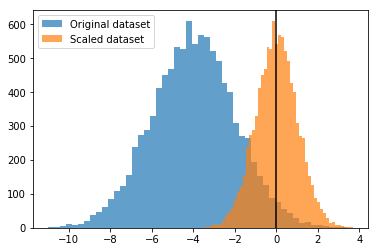

In [16]:
demonstrate_scaling()

### Now let's build a neural net

In [17]:
np.random.seed(3)

In [18]:
# A single hidden layer net, trained with stochastic gradient descent
model = Sequential()
model.add(Dense(32, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="sgd")

history = model.fit(X_train, y_train, epochs=15, verbose=0, validation_data=(X_test, y_test))

### We're going to need some way to see how well we did

In [19]:
def evaluate_net(model, history, X_test=X_test, y_test=y_test):
    """Plot a net's training history and calculate its RMSE."""
    
    plt.semilogy(history.history["loss"], lw=3)
    plt.semilogy(history.history["val_loss"], lw=3, alpha=0.7)
    plt.title("Final RMSE : {:.2f}".format((model.evaluate(X_test, y_test, verbose=0))**0.5))
    plt.xlabel("Epochs")
    plt.ylabel("MSE loss")
    plt.legend(["Train", "Test"])

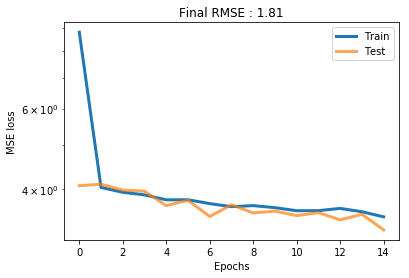

In [20]:
evaluate_net(model, history)

### We need to go deeper

Well, at least most of us *want* to. However, before we add more layers, there are a few things we need to think about :

- learning rate
- minibatch size
- number of epochs

### Learning rate

If your learning rate is too high, you can overshoot in gradient descent, never finding the minimum, or worse, diverging completely. If your learning rate is too low, you will take a very long time training.

In [21]:
from keras.optimizers import SGD
from keras.callbacks import TerminateOnNaN

def train_net(lr=0.01, batch_size=32, epochs=20, verbose=0, large=False):
    """Fit a neural network, returning the trained model and its history."""
    
    # Fix the random seed
    np.random.seed(3)
    
    # Start with a model with a single 32-neuron hidden layer
    model = Sequential()
    model.add(Dense(32, activation="relu", input_dim=X_train.shape[1]))
    
    # If we want a much larger net, throw in a couple of 256-neuron layers
    if large:
        model.add(Dense(256, activation="relu"))
        model.add(Dense(256, activation="relu"))
        
    # The output layer is a single linear unit
    model.add(Dense(1, activation="linear"))
    
    # Train the model using vanilla stochastic gradient descent
    model.compile(loss="mse", optimizer=SGD(lr))
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=int(batch_size), 
        validation_data=(X_test, y_test),
        callbacks=[TerminateOnNaN()],
        verbose=verbose
    )
    
    # In the case of first-epoch termination due to NaN,
    # fill in the val_loss if it was never evaluated
    if "val_loss" not in history.history:
        history.history["val_loss"] = [np.nan]
        
    return model, history

def compare_nets(first_model, first_history, second_model, second_history):
    """Plot, side by side, the losses of two neural networks with a shared y axis."""
    
    # Create a figure that's about page width
    plt.figure(figsize=(15, 5))
    
    # Plot both models side by side
    ax = plt.subplot(121)
    evaluate_net(first_model, first_history)
    plt.subplot(122, sharey=ax)
    evaluate_net(second_model, second_history)
    
    # Remove redundant white space
    plt.tight_layout()

Batch 6: Invalid loss, terminating training


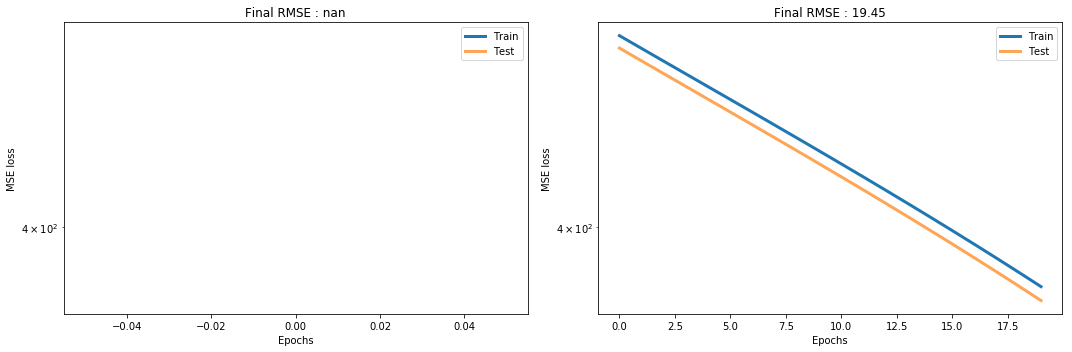

In [22]:
lr_high_model, lr_high_history = train_net(lr=0.1)
lr_low_model, lr_low_history = train_net(lr=1e-6)

compare_nets(lr_high_model, lr_high_history, lr_low_model, lr_low_history)

### Minibatches

A minibatch is like training on a small part of your data at a time : you forwards-propagate your minibatch, backpropagate your errors, and adjust your weights using gradient descent. Then you do the same on another minibatch. The advantage is that you update your weights a lot more often than in a single minibatch.

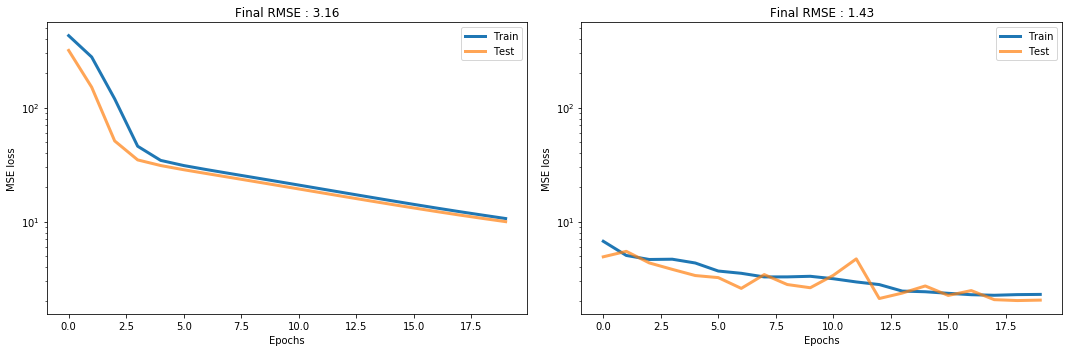

In [23]:
# Slow cell !
mb_large_model, mb_large_history = train_net(batch_size=len(X_train)/2)
mb_small_model, mb_small_history = train_net(batch_size=8)

compare_nets(mb_large_model, mb_large_history, mb_small_model, mb_small_history)

### Number of epochs

At the beginning, the more you train, the better your model gets. At some point, however, your model begins to overfit -- it stops learning the general function that maps your inputs to your outputs, and it begins learning the small intricacies of your training set. At this point, your training loss is still decreasing, but the test loss begins increasing.

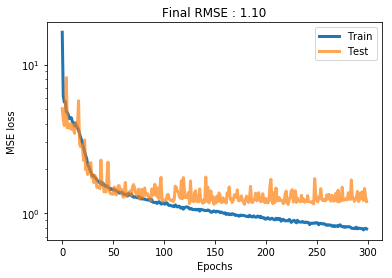

In [24]:
# Warning : very slow cell !
long_train_model, long_train_history = train_net(epochs=300, lr=0.003, large=True)
evaluate_net(long_train_model, long_train_history)

### There are many other things to consider

- depth of the neural net
- number of neurons in each layer
- initial distribution of weights
- choice of optimiser and error metric
- regularisation, dropout, and batch normalisation

So what might a slightly more beefy, carefully-built net look like ?

In [25]:
from keras.layers import BatchNormalization, Activation

np.random.seed(3)

# This time, we'll have three hidden layers with 32 neurons each
# We'll also batch-normalise, regularise, initialise our weights carefully 
# Finally, we're using a more sophisticated grad descent algorithm : Adam
model = Sequential()
model.add(Dense(32, kernel_initializer="he_normal", kernel_regularizer="l2", input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(32, kernel_initializer="he_normal", kernel_regularizer="l2"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(32, kernel_initializer="he_normal", kernel_regularizer="l2"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1, kernel_initializer="he_normal", kernel_regularizer="l2", activation="linear"))

model.compile(loss="mse", optimizer="adam")

This network has a lot more going on than our previous ones...

#### Kernel initialisation

If you recall, when we build a neural net, we pick the weights randomly, so that during training, we can take steps in a direction that'll improve the predictive power of the network. "Randomly" can mean many different things, however. Over time, people have discovered a number of different random selection methods that may help the net train faster. The [method used here](http://arxiv.org/abs/1502.01852) is one that's well-suited to the RELU activation function. Making a good choice in random weight initialisation can speed up training; making a poor choice can stop training completely.

#### Batch normalisation

Batch normalisation does the same thing as we did with our input data -- normalises it to zero mean, unit variance -- but at each layer, before the activation function. We do it here for the same reasons : because it can speed up training and help deeper nets converge faster.

#### Regularisation

We've added some L2 regularisation to our weights. Without going into much detail, regularisation keeps the net from overfitting and speeds up convergence by ensuring that the weights stay small. Gradient descent will more easily be able to influence the direction of a small weights vector, allowing us to explore more of the parameter space when training.

#### Adam

[Adam](https://arxiv.org/abs/1412.6980), or *adaptive momentum*, builds upon a number of enhancements to standard gradient descent by adding a momentum term that smoothes things out. In practice, Adam is often a great choice.

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
__________

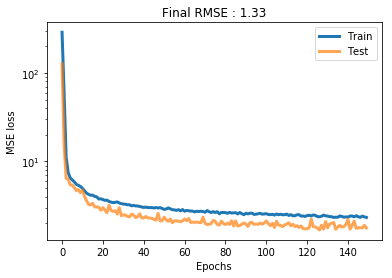

In [27]:
# Warning : slow cell !
history = model.fit(X_train, y_train, epochs=150, batch_size=64, verbose=0, validation_data=(X_test, y_test))
evaluate_net(model, history)

### Too Long; Didn't Train

- There's no **single correct architecture** for a problem or dataset
- A lot of decisions can be made **scientifically**, but others are still **intuition**
- Neural nets can be very **powerful** models, but are **slow** to train
- They don't naturally allow much introspection

I strongly recommend reading through [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com) by [Michael Nielsen](http://michaelnielsen.org/). It's a wonderfully written text on neural nets, and it's freely available online.